<a href="https://www.kaggle.com/code/aisuko/training-a-simple-dense-neural-network?scriptVersionId=137097672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Training a dense neural network

Let's focus on the problem of handwritten digit recognition. It is a classification problem, because for each input image we need to specify the class - which digit it is.

In this unit, we start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a `perceptron`). We will recap the way neural networks are defined in PyTorch, and how the training algorithm works. 

In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torchinfo import summary

In [3]:
data_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

data_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 80034248.58it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 35471652.66it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20111292.56it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14906517.03it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Fully-connected dense neural networks

A basic `neural network` in PyTorch consists of s number of `layers`. The simplest network would inlcude just one fully-connected layer, which is called `Linear` layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class).

<figure><img src="https://hostux.social/system/media_attachments/files/110/732/942/217/701/604/original/e82cd31dfa1df512.png" alt="" width="1000"><figcaption><p>Source from Microsoft Learning</p></figcaption></figure>

As we discussed above, the dimension of our digit images is $1*28*28$, i.e. each image contains $28*28 = 784$ different pixels. Because linear layer expects its input as one-dimensional vector, we need to insert another layer into the network, called `Flatten`, to change input tensor shape from $1*28*28 to 784$.

After `Flattern`, there is a main linear layer (called `Dense` in PyTorch terminology) that converts 784 inputs to 10 outputs - one per class. We want n-th output of the network to return the probability of the input digit being equal to n.

Because the output of a fully-connected layer is not normalized to be between 0 and 1, it cannot be thought of as probability. Moreover, if want outputs to be probabilities of different digits, they all need to add up to 1. To turn **output vectors** into **probability vector**, a function called `Softmax` is often used as the last activation function in a classification neural network. For example, $softmax([-1,1,2])=[0.035,0.25,0.705]$.

  > In PyTorch, we often prefer to use `LogSoftmax` function, which will also compute logarithms of output probabilities. To turn the output vector into the actual probabilities, we need to take `torch.exp` of the output.
  
Thus, the architecture of our network can be represented by the following sequence of layers:

<figure><img><img src="https://hostux.social/system/media_attachments/files/110/732/956/489/730/002/original/55c2524f7244f9c2.png" alt="" width="1000"><figcaption><p>Source from Microsoft Learning</p></figcaption></figure>

It can be defined in PyTorch in the following way, using `Sequential` syntax:

In [4]:
net = nn.Sequential(
    nn.Flatten(), # 28x28 -> 784 inputs to make sure the input is a vector
    nn.Linear(784,10), # 784 inputs, 10 outputs
    nn.LogSoftmax(dim=1) # log probabilities is aim to make the output more stable
)

## Training the network

A network defined in this way can take any digit as input and produce a vector of probabilities as an output. Let's see how this network performs by giving it a digit from our datasets:

In [5]:
print('Digit to be predicted: ', data_train[0][1])
torch.exp(net(data_train[0][0])) # to turn the output vector into the actual probabilities

Digit to be predicted:  5


tensor([[0.0884, 0.1100, 0.0862, 0.1119, 0.0765, 0.0830, 0.0874, 0.1304, 0.1288,
         0.0974]], grad_fn=<ExpBackward0>)

> Because we use `LogSoftmax` as final activation of our network, we pass network output through `torch.exp` to get probabilities.

As you can see the network predicts similar probabilities for each digit. This is because it has not been trained on how to recognize the digits. We need to give it our training data to train it on our dataset.

To train the model we will need to create `batches` from our dataset of a certain size, let's say 64. PyTorch has an object called `DataLoader` that can create batches of our data for us automatically.

In [6]:
train_loader = DataLoader(data_train, batch_size=64)
test_loader = DataLoader(data_test, batch_size=64) # we can use larger batch size for testing

The training process steps are as follows:
1. We take a minibatch from the input dataset, which consists of input data (features) and expected result (label).
2. We calculate the predicted result for this minibatch.
3. The difference between this result and expected result is calculated using a special funciton called the `loss function`. Loss function shows how different the output of the network is from the expected output. The goal of our training is to minimize the loss.
4. We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called `learning rate`, and the details of optimization algorithm are defined in the `optimizer` object.
5. We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called an `epoch`.

Here is a function that performs one epoch training:

In [7]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    net.train() # put the network into training mode make sure the parameters are trainable
    total_loss,acc,count =0,0,0
    for features, labels in dataloader:
        optimizer.zero_grad() # reset the gradients to zero before each batch to avoid accumulation
        out=net(features) # forward pass of the mini-batch through the network to obtain the outputs
        loss=loss_fn(out,labels) # compute the loss
        loss.backward() # compute the gradients of the loss with respect to all the parameters of the network
        optimizer.step() # update the parameters of the network using the gradients to minimize the loss
        total_loss+=loss # accumulate the loss for inspection
        _,preds=torch.max(out,dim=1) # compute the predictions to obtain the accuracy
        acc+=(preds==labels).sum() # accumulate the correct predictions
        count+=len(labels) # accumulate the total number of examples
    return total_loss.item()/count, acc.item()/count # return the loss and accuracy

train_epoch(net, train_loader)

(0.005932151794433594, 0.8928333333333334)

This function takes the following parameters:
* `Neural network`
* `DataLoader` which defines the data to train on
* `Loss Function` which is a function that measures the difference between the expected result and the one produced by the network. In most of the classification tasks `NLLLoss` is used, so we will make it a default.
* `Optimizer` which defined an `optimization algorithm`. The most traditional algorithm is `stochastic gradient descent`, but we will use a more advanced version called `Adam` by default.
* `Learning rate` defines the speed at which the network learns. During learning, we show the same data multiple times, and each time weights are adjusted. If the learning rate is too high, new values will overwrite the knowledge from the old ones, and the network would perform badly. If the learning rate is too small it results in a very slow learning process.

Here is what we do when training:
* Switch the network to training mode using `net.train()`
* Go over all batches in the dataset, and for each batch do the following:
  * compute predictions made by the network on this batch (out)
  * compute `loss` which is the discrepancy between predicted and expected values
  * try to minimize the loss by adjusting weights of the network using `loss.backward()` and `optimizer.step()`
  * compute the number of correctly predicted cases in this batch by comparing `out` and `labels`

The function calculates and returns the average loss per data item, and training accuracy (percentage of cases guessed correctly). By observing this loss during training we can see whether the network is improving and learning from the data provided.

It is also important to control the accuracy on the test dataset (also called `validation accuracy`). A good neural network with a lot of parameters can predict with decent accuracy on any training dataset, but it may poorly generalize to other data. That's why in most cases we set aside part of our data, and then periodically check how well the model performs on them. Here is the function to evaluate the network on test dataset:

In [8]:
def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval() # put the network into evaluation mode to deactivate the dropout layers
    count,acc,loss =0,0,0
    with torch.no_grad(): # deactivate autograd to save memory and speed up computations
        for features, labels in dataloader:
            out=net(features) # forward pass of the mini-batch through the network to obtain the outputs
            loss += loss_fn(out,labels) # compute the loss
            preds=torch.max(out,dim=1)[1] # compute the predictions to obtain the accuracy
            acc+=(preds==labels).sum() # accumulate the correct predictions
            count+=len(labels) # accumulate the total number of examples
    return loss.item()/count, acc.item()/count # return the loss and accuracy

validate(net, test_loader)

(0.005875687789916992, 0.8936)

Similarly to `train` function, we return average loss and accuracy on test dataset.

## Overfitting

Normally when training a neural network, we train the model for several epochs observing training and validation accuracy. In the beginning, both training and validation accuracy should increase, as the network picks up the patterns in the dataset. However, at some point it can happen that training accuracy increases while validation accuracy starts to decrease. That would be an indication of `overfitting`, that is model does well on your training dataset, but not on new data.

Below is the training function that can be used to perform both training and validation. It prints the training and validation accuracy for each epoch, and also returns the history that can be used to plot the loss and accuracy on the graph.

In [9]:
def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr) # use Adam optimizer if not provided
    res = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc':[]}
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer,lr=lr, loss_fn=loss_fn)
        vl,va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

# Re-initialize the networks to start from scratch in order to compare the results
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,10),
    nn.LogSoftmax(dim=1)
)

hist = train(net, train_loader, test_loader, epochs=5)

Epoch  0, Train acc=0.893, Val acc=0.892, Train loss=0.006, Val loss=0.006
Epoch  1, Train acc=0.910, Val acc=0.898, Train loss=0.005, Val loss=0.006
Epoch  2, Train acc=0.913, Val acc=0.898, Train loss=0.005, Val loss=0.006
Epoch  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Epoch  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


This function logs messages with the accuracy on training and validation data from each epoch. It also returns this data as a dictionary (called `history`). We can then visualize this data to better understand our model training.

In [10]:
def plot_results(hist):
    plt.figure(figsize=(10,5)) # figure is used to create a new figure
    plt.subplot(121) # subplot is used to create a new subplot on a grid
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend() # legend is used to add a legend to the plot
    plt.subplot(122) # plot the loss
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

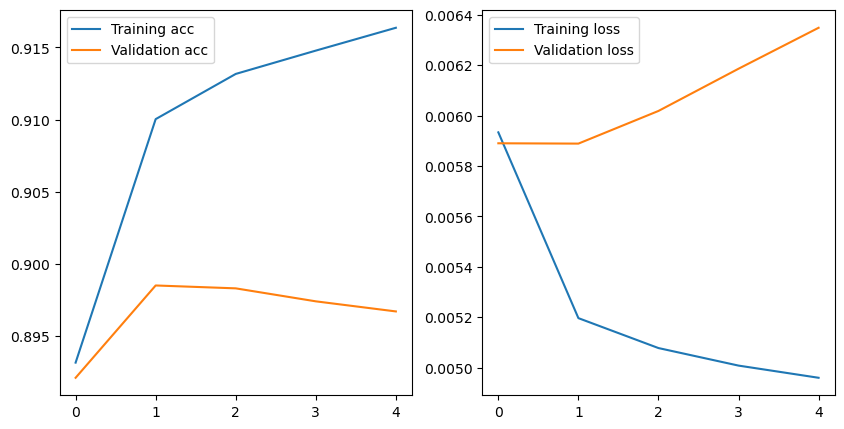

In [11]:
plot_results(hist)

The diagram on the left shows the `training accuracy` increasing (which corresponds to the network learning to classify our training data better and better), while `validation accuracy` starts to fall. The diagram on the right show the `training loss` and `validation loss`, you can see the `training loss` decreasing (meaning its performing better) and the `validation less` increasing (meaning its performing worse). These graphs would indicate the model is `overfitting` to the training data.

## Visualizing network weights

The `Dense` layer in our network is also called `linear`, because it performs linear transformation of its input, which can be defined as $y = Wx+b$, where $W$ is a matrix of weights, and $b$ is bias. Weights matrix $W$ is in fact responsible for what our network can do, i.e. for recognizing digits. In our case, it has size of $784*10$, because it produces 10 outputs (one output per digit) for an input image.

Lets visualize our weights of our neural network and see what they look like. When the network is more complex than just one layer it can be a difficult to visualize the results like this, because in complex network weights do not make much sense when visualized. However, in our case each of 10 dimensions of weights matrix $W$ corresponds to individual digits, and thus can be visulized to see how the digit  recognition takes place. For example, if we want to see if our number is 0 or not, we will multiply input digit by $W[0]$ and pass the result through a softmax normalization to get the answer.

In the code below, we will first get the matrix $W$ into `weight_tensor` variable. It can be obtained by calling the `net.parameters()` method (which returns both $W$ and $b$), and then calling `next` to get the first of two parameters. Then we will go over each dimention, reshape it to $28*28$ and visualize it as an image. You cane see that 10 weight tensor dimensions somewhat resemble the average shape of the digits they classify:

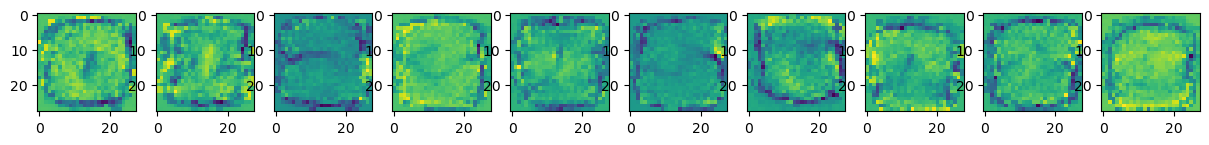

In [12]:
weight_tensor = next(net.parameters())
fig,ax=plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

## Multi-layerd perceptron

To further increase accuracy, we may want to include one or more `hidden layers`.

A hidden layer is a layer that is not directly connected to the input or output of the network. It is hidden in the sense that it is not the layer that we see as input or output of the network. The hidden layer is where all the computation is done. The more hidden layers we have, the more complex functions we can create.

Here we are going to use the non-linear activation function which is called `ReLU`. It is important to introduce those non-linear activation functions, because they are one of the reasons neural networks achieve high expressive power. Indeed, it can be demonstrated mathematically that if a network consisted just of a series of linear layers, it would essentially be equivalent to one linear layer. Thus inserting non-linear functions in between layers is important!

`ReLU` is a simplest activation function, which is defined as follows:

$$
\mathrm{ReLU}(x) =\begin{cases} 0 & x<0 \\ x & x\geq 0 \end{cases}
$$

Other activation functions used in deep learning are sigmoid and tanh, but ReLU is most often used in computer vision, because it can be quickly computed, and using other functions does not bring any significant benefits.

This network can be defined in PyTorch with this code:

In [13]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,100), # 784 inputs, 100 outputs
    nn.ReLU(),          # ReLU activation function
    nn.Linear(100,10),  # 100 inputs, 10 outputs
    nn.LogSoftmax(dim=1)
)


summary(net, input_size=(1,28,28), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─ReLU: 1-3                              [1, 100]                  --
├─Linear: 1-4                            [1, 10]                   1,010
├─LogSoftmax: 1-5                        [1, 10]                   --
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

Here we use `summary()` function to display a detailed layer-by-layer structure of a network with some other useful information. In particular, we can see:

* Layer-by-layer strucutre of a network, and output size of each layer
* Number of parameters of each layer, as well as for the whole network. The more parameters the network has, the more data samples it needs to be trained on without `overfitting`.

Let's see how the number of parameters is calculated. First linear layer has 784 inputs and 100 outputs. The layer is defined by $W1*x+b1$, where $W1$ has size $784 * 100$, and $b1-100$. Thus total number of parameters for this layer is $784*100+100=78500$. Similarly, number of parameters for the second layer is $100*10+10=1010$. Activation functions, as well as `Flatten` layers do not have parameters.

There is another syntax that we can use to define the same network by using classes:

In [14]:
from torch.nn.functional import relu, log_softmax

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = log_softmax(x, dim=1)
        return x

net = MyNet()

summary(net, input_size=(1,28,28), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Linear: 1-2                            [1, 100]                  78,500
├─Linear: 1-3                            [1, 10]                   1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.32
Estimated Total Size (MB): 0.32

You can see that the structure of a neural network is the same as with the `Sequential` defined network, but the definition is more explicit. Our custom neural network is represented by a class inherited from `torch.nn.Module` class.

Class definition consists of two parts:
* In the constructor `__init__` we define all layers that will have. Those layers are stored as internal variable of the class, and PyTorch will automatically know that parameters of those layers should be optimized when training. Internally, PyTorch uses `parameters()` method to look for all trainable parameters, and `nn.Module` will automatically collect all trainable parameters from all sub-modules.
* We define the `forward` method that does the forward pass computation of our neural network. In our case, we start with a parameters tensor `x`, and explicitly pass it through all the layer and activation functions, starting from `flattern`, up to final linear layer `out`. When we apply our neural network to some input data `x` by writing `out = net(x)`, the `forward` method is called.

In fact, `Sequantial` networks are represented in a very similar manner, they just store a list of layers and apply them sequentially during the forward pass. Here we have a chance to represent this process more explicity, which eventually gives us more flexibility. That is one of the reasons that using classes for neural network definition is a recommended and preferred practice.

You can now try to train this network using exactly the same `train` function that we've defined above:

Epoch  0, Train acc=0.924, Val acc=0.894, Train loss=0.004, Val loss=0.006
Epoch  1, Train acc=0.956, Val acc=0.949, Train loss=0.002, Val loss=0.003
Epoch  2, Train acc=0.963, Val acc=0.959, Train loss=0.002, Val loss=0.003
Epoch  3, Train acc=0.969, Val acc=0.954, Train loss=0.002, Val loss=0.003
Epoch  4, Train acc=0.971, Val acc=0.948, Train loss=0.002, Val loss=0.004


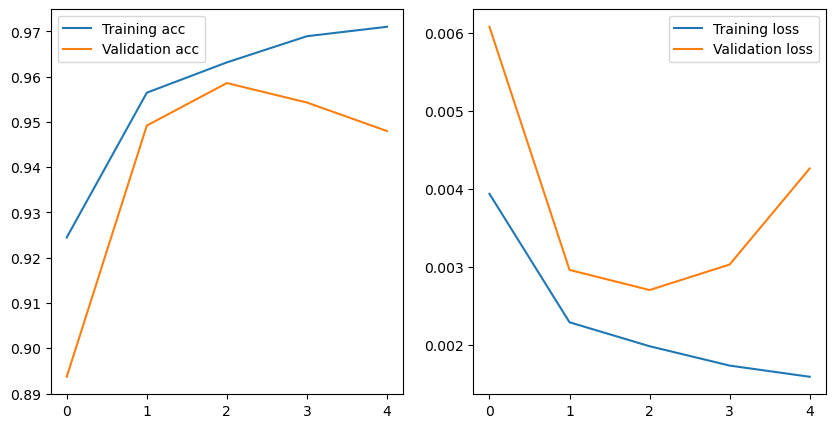

In [15]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

## Summary
Training a neural network in PyTorch can be programmed with a training loop. It may seem like a complicated process, but in real life we need to write it once, and we can then re-use this training code later without changing it.

We can see that a single-layer and multi-layer dense neural networks show relatively good performance, but if we try to apply them to real-world images, the accuracy will not be too high. So, we need to use `convolutions` to improve the performance.